Hello, my name is Aaron Kann.  In this data analysis, we will continue to break down data from the 2023-2024 Premier League in order to determine
if xG is a better metric to predict future goalscoring than a player's goal output, and if sample size is a determining factor in the effeciency of both metrics. 

Logically, what I am expecting is that, in a small sample size, xG would be a better determiner than G because goalscoring opportunites are subject to lesser variance than goals scored, but over time G becomes a better metric because it also measures a player's finishing ability on top of a player's ability to generate chances.  

Let's see if the data supports this conclusion!

In [1]:
import csv, sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# read in the data, determining if we have to step back a directory based on the file location

# if Premmier_League_Team_Stats.csv is in the same directory as the script
if not 'Premier_League_Team_Stats.csv' in os.listdir():
    os.chdir('..')
team_df = pd.read_csv('Premier_League_Team_Stats.csv')

data_folder = 'Premier_League_Player_Matchlogs'
data_files = os.listdir(data_folder)
dfs = []

for file in data_files:
    if file.endswith('.csv'):
        file_path = os.path.join(data_folder, file)
        # read the csv file and process the data
        df = pd.read_csv(file_path)
        # df = add_name_to_df(df, file)
        dfs.append(df)

dfs[0].head()

,game_started,game_count,dayofweek,comp,round,venue,result,team,opponent,position,...,gca,passes_completed,passes,passes_pct,progressive_passes,carries,progressive_carries,take_ons,take_ons_won,match_report
0,Y,1,Mon,Premier League,Matchweek 1,Home,W 1-0,Manchester Utd,Wolves,RB,...,1,47,51,92.2,3,42,1,4,3,Match Report
1,Y,2,Sat,Premier League,Matchweek 2,Away,L 0-2,Manchester Utd,Tottenham,RB,...,0,38,44,86.4,1,29,1,2,1,Match Report
2,Y,3,Sat,Premier League,Matchweek 3,Home,W 3-2,Manchester Utd,Nott'ham Forest,RB,...,0,58,69,84.1,9,55,7,2,1,Match Report
3,Y,4,Sun,Premier League,Matchweek 4,Away,L 1-3,Manchester Utd,Arsenal,RB,...,0,44,54,81.5,2,30,2,0,0,Match Report
4,N,5,Sat,Premier League,Matchweek 5,Home,L 1-3,Manchester Utd,Brighton,CB,...,0,10,11,90.9,1,5,0,0,0,Match Report


The data we need is the first half totals, and the second half totals, thus, it makes sense to divide the data in that way.

For now, the first half of player's appearaces will be seperate from the second half of a player's appearances, as opposed to dividing the data after Matchweek 18.  This makes sense to me because it allows for equal sample sizes on both ends, as well as making it easier on myself to not have to check to see if early matchweeks got postponed to a later date, which would corrupt the data a bit.

In [3]:
output_df_as_list = list()
print(len(dfs))

for df in dfs: #iterate through individual players
    to_be_appended = {
        'xg_1h': 0,
        'g_1h': 0,
        'xga_1h': 0,
        'a_1h': 0,
        'xg_2h': 0,
        'g_2h': 0,
        'xga_2h': 0,
        'a_2h': 0,
    }

    total_rows = len(df.index)

    #skip players with less than 10 games (not enough data)
    if total_rows < 10:
        continue 

    for index, row in df.iterrows(): #iterate through individual games
        # check to make sure xG is tracked
        if 'xg' not in row:
            continue

        if index < total_rows // 2:
            to_be_appended['xg_1h'] += row['xg']
            to_be_appended['g_1h'] += row['goals']
            to_be_appended['xga_1h'] += row['xg_assist']
            to_be_appended['a_1h'] += row['assists']
        else:
            to_be_appended['xg_2h'] += row['xg']
            to_be_appended['g_2h'] += row['goals']
            to_be_appended['xga_2h'] += row['xg_assist']
            to_be_appended['a_2h'] += row['assists']
    # end for loop (games)

    print(to_be_appended)
    output_df_as_list.append(to_be_appended)
    print(len(output_df_as_list))
# end for loop (players)



df = pd.DataFrame(output_df_as_list)
df.head()

270
{'xg_1h': 0.0, 'g_1h': 0, 'xga_1h': 1.2000000000000002, 'a_1h': 1, 'xg_2h': 0.0, 'g_2h': 0, 'xga_2h': 0.30000000000000004, 'a_2h': 1}
1
{'xg_1h': 5.1000000000000005, 'g_1h': 6, 'xga_1h': 2.0, 'a_1h': 0, 'xg_2h': 3.6999999999999997, 'g_2h': 1, 'xga_2h': 0.7, 'a_2h': 1}
2
{'xg_1h': 0.0, 'g_1h': 0, 'xga_1h': 0.6, 'a_1h': 2, 'xg_2h': 0.0, 'g_2h': 0, 'xga_2h': 0.7999999999999999, 'a_2h': 0}
3
{'xg_1h': 0.4, 'g_1h': 0, 'xga_1h': 1.2, 'a_1h': 2, 'xg_2h': 0.2, 'g_2h': 1, 'xga_2h': 0.2, 'a_2h': 1}
4
{'xg_1h': 3.8000000000000007, 'g_1h': 3, 'xga_1h': 1.7, 'a_1h': 2, 'xg_2h': 4.3999999999999995, 'g_2h': 4, 'xga_2h': 3.2, 'a_2h': 2}
5
{'xg_1h': 9.3, 'g_1h': 9, 'xga_1h': 1.1, 'a_1h': 0, 'xg_2h': 10.9, 'g_2h': 12, 'xga_2h': 2.7, 'a_2h': 2}
6
{'xg_1h': 0.0, 'g_1h': 1, 'xga_1h': 0.6000000000000001, 'a_1h': 1, 'xg_2h': 3.400000000000001, 'g_2h': 4, 'xga_2h': 2.9000000000000004, 'a_2h': 4}
7
{'xg_1h': 3.6, 'g_1h': 3, 'xga_1h': 1.2, 'a_1h': 1, 'xg_2h': 1.9999999999999998, 'g_2h': 2, 'xga_2h': 3.80000

,xg_1h,g_1h,xga_1h,a_1h,xg_2h,g_2h,xga_2h,a_2h
0,0.0,0,1.2,1,0.0,0,0.3,1
1,5.1,6,2.0,0,3.7,1,0.7,1
2,0.0,0,0.6,2,0.0,0,0.8,0
3,0.4,0,1.2,2,0.2,1,0.2,1
4,3.8,3,1.7,2,4.4,4,3.2,2


Now that we have the data, let's see what an ordinary linear regression can get us, for both xG and G

In [4]:
# Sample data
X = np.array(df['xg_1h'])
Y = np.array(df['g_2h'])

# Add a constant to the independent variable for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Calculate the residual standard deviation
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     249.2
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           3.83e-40
Time:                        14:30:40   Log-Likelihood:                -574.07
No. Observations:                 270   AIC:                             1152.
Df Residuals:                     268   BIC:                             1159.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4774      0.158      3.023      0.0

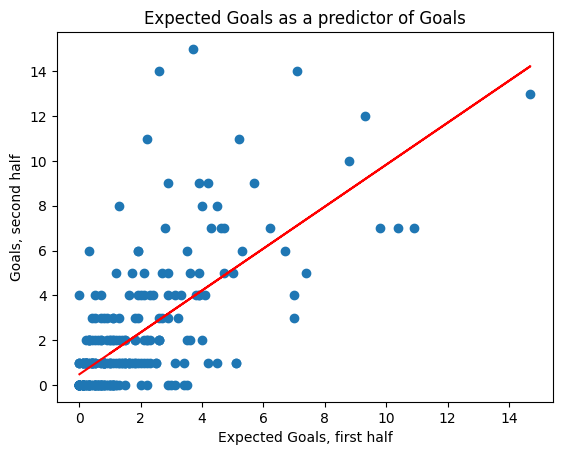

In [5]:
# Plot the regression line, including the line of best fit
plt.scatter(X[:, 1], Y)

# Add the title and labels
plt.title('Expected Goals as a predictor of Goals')
plt.xlabel('Expected Goals, first half')
plt.ylabel('Goals, second half')


# Add the regression line
plt.plot(X[:, 1], model.predict(X), color='red')

In [6]:
X = np.array(df['g_1h'])
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     168.7
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.96e-30
Time:                        14:30:41   Log-Likelihood:                -596.90
No. Observations:                 270   AIC:                             1198.
Df Residuals:                     268   BIC:                             1205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7497      0.167      4.499      0.0

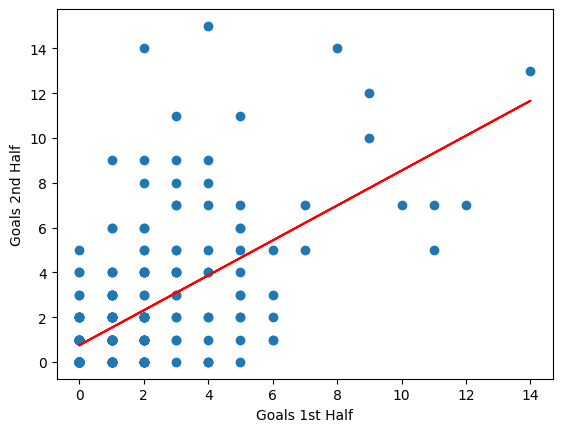

In [7]:
# Plot the regression line, including the line of best fit
plt.scatter(X[:, 1], Y)
#label the axes
plt.xlabel('Goals 1st Half')
plt.ylabel('Goals 2nd Half')
plt.plot(X[:, 1], model.predict(X), color='red')

## Conclusion

We can clearly see that the xG regression has a higher R squared value, a lower standard error value, and the slope of the regression line is higher, indicating that First Half XG is a superior metric in general to measure second half goalscoring output than first half goals scored.  

## Additional Analyses

Now that we established xG as a better predictor of goals than goals, now we must ask ourselves, does overperformance help predict goals at all?  In other words, how much better is using both metrics as opposed to just the one?

We can perform a two variable regression to determine this.  

In [8]:
df['overperformance1h'] = df['g_1h'] - df['xg_1h']

X = np.array(df[['overperformance1h', 'xg_1h']])
Y = np.array(df['g_2h'])
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     124.2
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           7.50e-39
Time:                        14:30:41   Log-Likelihood:                -574.05
No. Observations:                 270   AIC:                             1154.
Df Residuals:                     267   BIC:                             1165.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4763      0.158      3.009      0.0

What we here is the opposite of what is to be expected: the trend shows that players who overperformed xG projections in the first half are in fact less likely to reach their xG mark in the second half as opposed to players who tallied the same first half xG and scored LESS goals.  It is important to note that this slope is within in the margin of error, however, so it is more likely that over/underperformance of xG wouldn't affect the linear model at all, given a larger sample size.  